# Preamble

In [2]:
from Likelihood_Functions import *

plt.rcdefaults()
fontsize = 14
rcParams['font.family'] = 'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
rcParams.update({'font.size':fontsize})

In [3]:
HomeDir = '/Users/kvantilburg/Dropbox/projects/LuminousBasin/LuminousBasin/code/master/likelihood/'
DataDir = HomeDir+'products_80610202001_orbit1_chu12_spatialARF/'
import sys
sys.path.insert(0, HomeDir)

# Parameters

In [4]:
m = 7.6 # axion mass
sigma_E = 0.166 # energy resolution

In [5]:
good_time_ints = [
(  3.37603080e+08,   3.37603330e+08),
(  3.37603330e+08,   3.37603380e+08),
(  3.37603380e+08,   3.37603380e+08),
(  3.37603580e+08,   3.37603581e+08),
(  3.37603630e+08,   3.37605080e+08),
(  3.37605081e+08,   3.37605230e+08)]
duration = np.max(good_time_ints)- np.min(good_time_ints)

In [6]:
# time bins
N_bins_t = 10
bins_t = np.linspace(good_time_ints[1][0], good_time_ints[-1][1], N_bins_t+1)
# energy bins
width_E = 0.04 # energy bin width is 40 keV
bins_E = np.arange(1.6,200.01,width_E)

In [7]:
list_file_events = [DataDir+'event_lists/'+file for file in listdir(DataDir+'event_lists/') if file[0:2]=='nu'] #select only files starting with 'nu'
file_box_centers = DataDir+'box_centers.txt'
list_file_arf = [DataDir+'arfs/'+file for file in listdir(DataDir+'arfs/')]

# Load Data

In [8]:
df_data = load_data(m,sigma_E,good_time_ints,bins_t,bins_E,list_file_events,file_box_centers,list_file_arf)

338it [00:35,  9.52it/s]


In [8]:
df_data

,detector,idx_t,idx_E,i1,i2,t,E,ra,dec,exp,arf,Omega,counts
0,A,0,47,-6,-6,337603330.0,3.48,170.889,3.75981,50.0,49.252083,1.0,0
1,A,0,47,-6,-6,337603330.0,3.48,170.889,3.75981,50.0,49.233070,1.0,0
2,A,0,47,-6,-5,337603330.0,3.48,170.881,3.77425,50.0,35.883560,1.0,0
3,A,0,47,-6,-5,337603330.0,3.48,170.881,3.77425,50.0,35.870827,1.0,0
4,A,0,47,-6,-4,337603330.0,3.48,170.872,3.78868,50.0,59.355179,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60835,B,9,63,6,2,337605040.0,4.12,171.009,3.97187,189.0,73.245651,1.0,0
60836,B,9,63,6,3,337605040.0,4.12,171.001,3.98630,189.0,60.073997,1.0,0
60837,B,9,63,6,4,337605040.0,4.12,170.992,4.00073,189.0,43.383308,1.0,0
60838,B,9,63,6,5,337605040.0,4.12,170.984,4.01517,189.0,42.593803,1.0,0


In [9]:
t = df_data['t'].to_numpy()
E = df_data['E'].to_numpy()
ra = df_data['ra'].to_numpy()
dec = df_data['dec'].to_numpy()
eps = df_data['exp'].to_numpy() * df_data['arf'].to_numpy() * df_data['Omega'].to_numpy()
counts = df_data['counts'].to_numpy()

# Likelihood

In [13]:
B0 = 1.0
T0 = 5.3
S0 = 10
alpha0 = 171
delta0 = 4.5

In [14]:
mu_bckg_slope = np.exp(-(E-m/2)/T0)
mu_sig_T = T_flux_template(ra,dec,t,duration,alpha0,delta0)
mu_sig_lineshape = np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)

In [21]:
mu = B0 * mu_bckg_slope + S0 * mu_sig_T * mu_sig_lineshape * eps 

In [22]:
%timeit mu = B0 * mu_bckg_slope + S0 * mu_sig_T * mu_sig_lineshape * eps

135 µs ± 825 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
def flux_model(t,E,ra,dec,m,B0,T0,S0,alpha0,delta0,duration,sigma_E=0.166):
    flux_bckg = B0*np.exp(-(E-m/2)/T0)
    flux_signal = S0 * T_flux_template(ra,dec,t,duration,alpha0,delta0) * np.exp(-(E-m/2)**2/(2*sigma_E**2)) / np.sqrt(2 * np.pi * sigma_E**2)
    return flux_bckg + flux_signal

In [18]:
mu = flux_model(t,E,ra,dec,m,B0,T0,S0,alpha0,delta0,duration) * eps

In [20]:
len(mu)

60840

In [15]:
%timeit flux_model(t,E,ra,dec,m,B0,T0,S0,alpha0,delta0,duration) * eps

9.17 ms ± 560 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
def likelihood(mu,counts):
    return -counts*np.log(mu)+mu+np.log(factorial_vec(counts))

In [25]:
%timeit likelihood(mu,counts)

4.43 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit np.sum(-counts*np.log(mu)+mu)

379 µs ± 4.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Tests

## Load events

In [28]:
df_events = load_events(list_file_events)
df_events

,detector,t,E,ra,dec
0,A,3.376033e+08,2.04,170.894753,3.983816
1,A,3.376033e+08,1.88,170.902966,3.914852
2,A,3.376033e+08,2.20,170.859849,3.921680
3,A,3.376033e+08,2.48,170.910495,3.991327
4,A,3.376033e+08,2.88,170.956349,3.940799
...,...,...,...,...,...
13688,B,3.376052e+08,2.64,170.911179,3.826770
13689,B,3.376052e+08,2.72,170.913917,3.998155
13690,B,3.376052e+08,2.24,170.905704,3.992010
13691,B,3.376052e+08,1.80,170.878328,3.922363


## Load exposure

In [9]:
df_exp = load_exp(bins_t,good_time_ints)
df_exp

,idx_t,exp
0,0,50.0
1,1,81.0
2,2,190.0
3,3,190.0
4,4,190.0
5,5,190.0
6,6,190.0
7,7,190.0
8,8,190.0
9,9,189.0


## Load box centers

In [10]:
df_box = load_box(file_box_centers)
df_box

,detector,i1,i2,ra,dec,delta_x,delta_y,rotation
0,A,0,0,170.926,3.89641,1.000',1.000',330
1,A,1,0,170.940,3.90475,1.000',1.000',330
2,A,-1,0,170.911,3.88808,1.000',1.000',330
3,A,2,0,170.955,3.91308,1.000',1.000',330
4,A,-2,0,170.897,3.87975,1.000',1.000',330
...,...,...,...,...,...,...,...,...
333,B,6,5,170.984,4.01517,1.000',1.000',330
334,B,-6,-6,170.902,3.75640,1.000',1.000',330
335,B,6,-6,171.076,3.85640,1.000',1.000',330
336,B,-6,6,170.802,3.92960,1.000',1.000',330


## Load ARFs

In [10]:
df_arf = load_arf(list_file_arf,bins_E,df_box)

338it [00:36,  9.30it/s]


In [11]:
df_arf

,detector,idx_E,i1,i2,ra,dec,arf
0,B,0,6,1,171.017,3.95743,0.414818
1,B,0,6,1,171.017,3.95743,0.573579
2,B,2,6,1,171.017,3.95743,0.790342
3,B,3,6,1,171.017,3.95743,1.085458
4,B,3,6,1,171.017,3.95743,1.464541
...,...,...,...,...,...,...,...
1384443,A,4091,3,3,170.944,3.96472,0.000000
1384444,A,4091,3,3,170.944,3.96472,0.000000
1384445,A,4093,3,3,170.944,3.96472,0.000000
1384446,A,4094,3,3,170.944,3.96472,0.000000


In [10]:
df_arf_m = load_arf_m(list_file_arf,bins_E,df_box,m,sigma_E)
df_arf_m

338it [00:34,  9.77it/s]


,detector,idx_E,i1,i2,ra,dec,arf
0,A,47,-6,-6,170.889,3.75981,49.252083
1,A,47,-6,-6,170.889,3.75981,49.233070
2,A,47,-6,-5,170.881,3.77425,35.883560
3,A,47,-6,-5,170.881,3.77425,35.870827
4,A,47,-6,-4,170.872,3.78868,59.355179
...,...,...,...,...,...,...,...
6079,B,63,6,2,171.009,3.97187,73.245651
6080,B,63,6,3,171.001,3.98630,60.073997
6081,B,63,6,4,170.992,4.00073,43.383308
6082,B,63,6,5,170.984,4.01517,42.593803


## Bin events

In [13]:
df_events_bin = binned_events(df_events,bins_t,bins_E,df_box,m,sigma_E)
df_events_bin

,detector,idx_t,idx_E,i1,i2,counts
0,A,0,53,-3,2,1
1,A,0,58,6,6,1
2,A,1,46,-6,2,1
3,A,1,47,2,3,1
4,A,1,48,-3,3,1
...,...,...,...,...,...,...
159,B,9,47,1,5,1
160,B,9,48,-3,6,1
161,B,9,49,3,6,1
162,B,9,50,-5,-2,1


# Plots

## Raw data

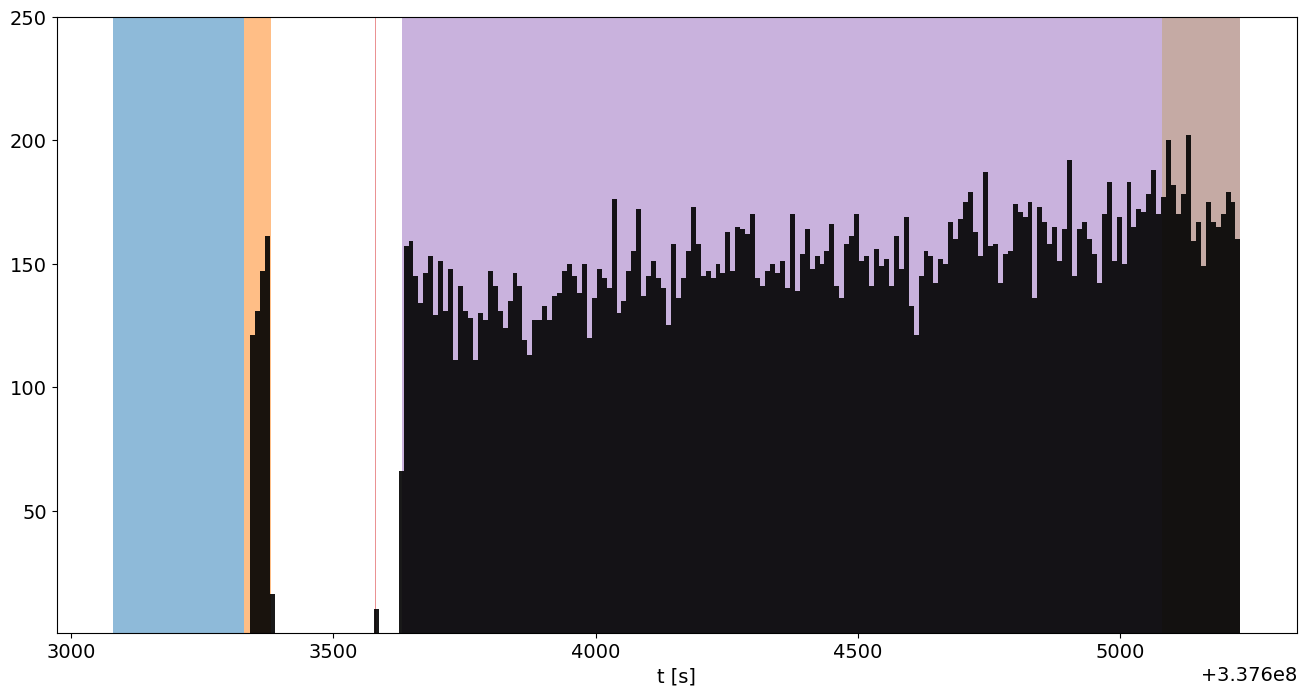

In [29]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
for i_int in range(len(good_time_ints)):
    ax.fill_between(x = good_time_ints[i_int], y1 = 2*[10**5],alpha=0.5)
ax.hist(df_events['t'],bins=200,color='black',alpha=0.9,log='False');
ax.set_xlabel('t [s]'); 
ax.set_yscale('linear')
ax.set_ylim(0.5,250);

(0.0, 100.0)

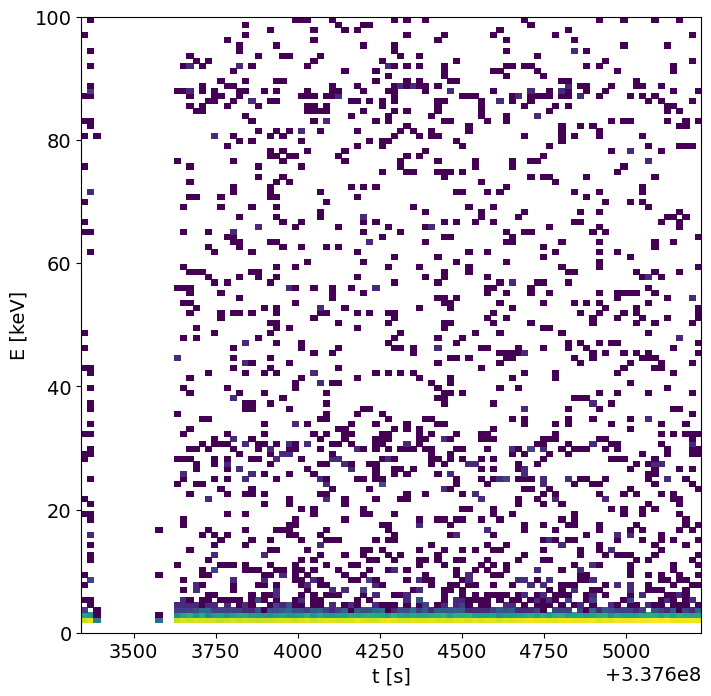

In [30]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.hist2d(df_events['t'],df_events['E'],bins=[100,200],norm=mp.colors.LogNorm());
ax.set_xlabel('t [s]'); ax.set_ylabel('E [keV]');
ax.set_ylim(0,100)